In [ ]:
"""
Inspect how outage events are distributed in size and duration (combined measure).
"""

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [77]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import simpson
from tqdm.notebook import tqdm

from lib import merge_in_geometry

In [61]:
years = list(range(2017, 2023))
root_dir = "data"
states = pd.read_csv(os.path.join(root_dir, "raw/states/state_codes.csv")).set_index("state_fips_code")
county_boundaries: gpd.GeoDataFrame = gpd.read_file(os.path.join(root_dir, "raw/counties/cb_2018_us_county_500k.shp"))

In [63]:
data_by_year = {}
for year in years:
    print(year)
    processed_path = os.path.join(root_dir, f"processed/outage/{year}.parquet")
    data = pd.read_parquet(processed_path)
    data.OutageFraction = np.clip(data.OutageFraction, 0, 1)
    data_by_year[year] = data

2017
2018
2019
2020
2021
2022


In [64]:
counties = set()
for year, data in data_by_year.items():
    counties = counties | set(data.index.get_level_values("CountyFIPS"))
counties = sorted(counties)

In [99]:
plot_dir = "plots/outage_integrals"
plot = False

integrals = []
for year in tqdm(years):
    
    df = data_by_year[year]
    for county_code in tqdm(counties):
        
        try:
            county = county_boundaries.sort_values("GEOID").set_index("GEOID").loc[county_code, :]
            state_code = county.STATEFP
            state_name = states.loc[int(state_code), "state_name"]
            county_name = county.NAME
        except Exception as e:
            #print(f"Couldn't find names for county: {county}")
            state_name = "-"
            county_name = "-"

        # whole timeseries April-October for single county
        try:
            data = df.loc(axis=0)[:, county_code].reset_index(level="CountyFIPS")
            complete_index = pd.date_range(f"{year}-04-01", f"{year}-10-31", freq="1H")
            data = data.reindex(index=complete_index, fill_value=0)
            data.index.name = "RecordDateTime"
        except KeyError:
            #print(f"Couldn't find outage data for {county_code}")
            continue

        # integrate OutageFraction over time
        time_axis_in_hours = data.reset_index()["RecordDateTime"].astype(int) / (3600 * 1E9)
        time_axis_in_hours = time_axis_in_hours - time_axis_in_hours.iloc[0]
        time_span = time_axis_in_hours.iloc[-1] - time_axis_in_hours.iloc[0]
        outage_integral = simpson(data.OutageFraction, x=time_axis_in_hours)
        # normalise by hours in period
        normalised_outage_integral = outage_integral / time_span
        
        integrals.append((year, county_code, normalised_outage_integral, time_span))
        
        if plot:
            
            path = os.path.join(plot_dir, f"{state_code}_{state_name}", f"{county_code}_{county_name}_{year}.png")
            if os.path.exists(path):
                continue

            f, ax = plt.subplots(figsize=(10,6))
            data["OutageFraction"].plot(ax=ax)
            ax.set_xlabel("Time")
            ax.set_ylabel("OutageFraction")
            ax.set_ylim(0, 1)
            ax.set_title(
                f"{county_name}, {state_name} ({county_code}), "
                r"$\frac{\int_{t_{0}}^{t_{n}} \mathrm{OutageFraction}(t) \ dt}{t_{n} - t_{0}} = $"
                f"{outage_integral:.2f}",
                pad=20
            )
            path = os.path.join(plot_dir, f"{state_code}_{state_name}", f"{county_code}_{county_name}_{year}.png")
            os.makedirs(os.path.dirname(path), exist_ok=True)

            f.savefig(path)
            plt.close(f)
            
df = pd.DataFrame(integrals, columns=["year", "county_code", "norm_int", "duration_h"])

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3035 [00:00<?, ?it/s]

  0%|          | 0/3035 [00:00<?, ?it/s]

  0%|          | 0/3035 [00:00<?, ?it/s]

  0%|          | 0/3035 [00:00<?, ?it/s]

  0%|          | 0/3035 [00:00<?, ?it/s]

  0%|          | 0/3035 [00:00<?, ?it/s]

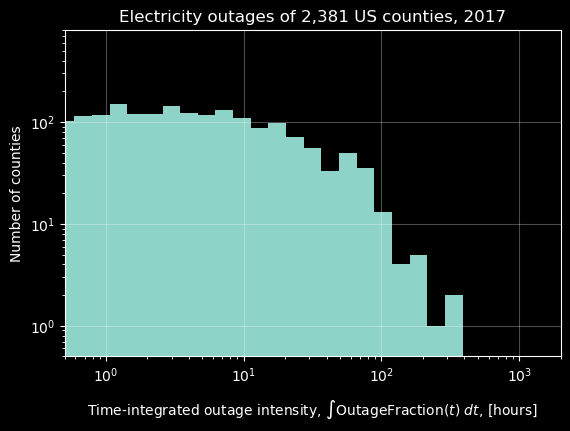

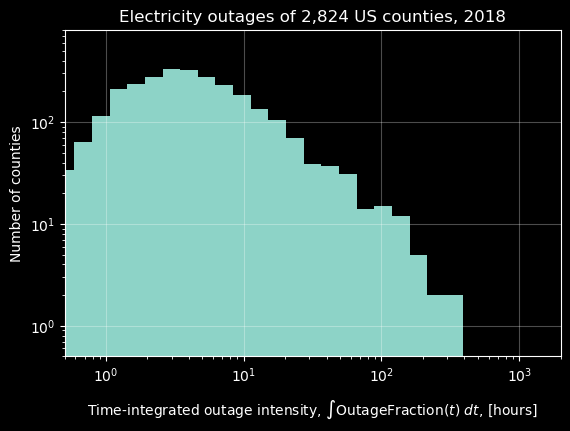

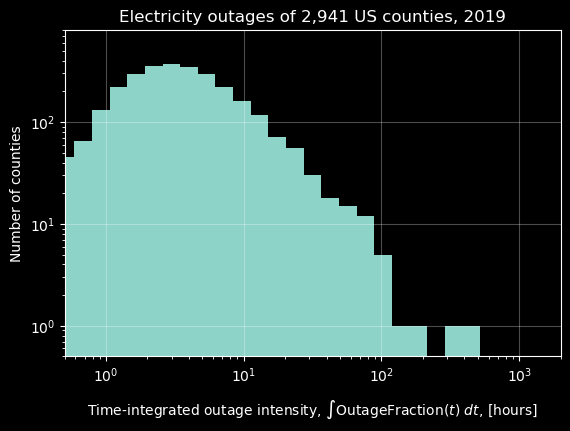

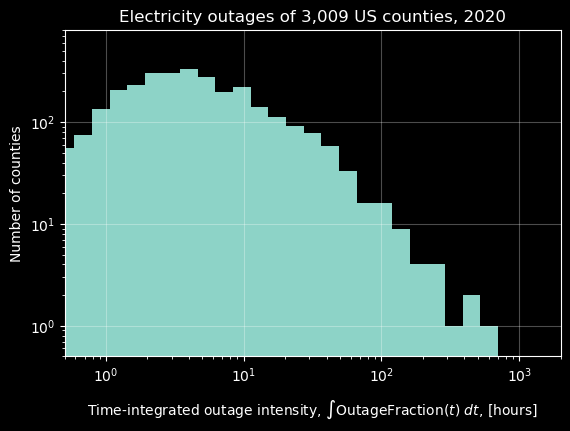

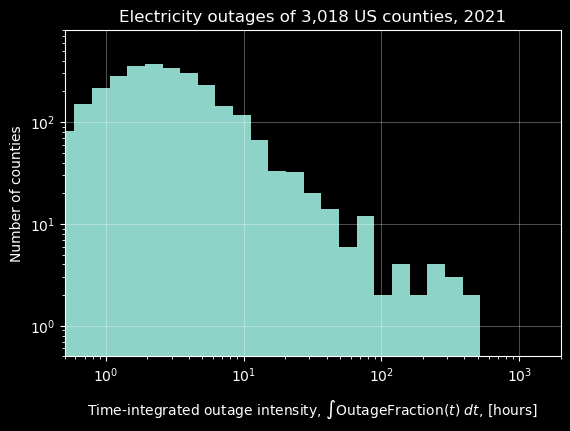

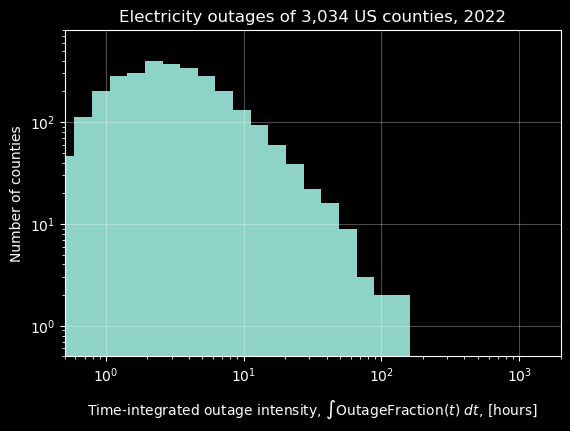

In [133]:
plt.style.use('dark_background')  # for cool points
plot_dir = "plots/outage_distributions/time_integ_outage_intensity"
os.makedirs(plot_dir, exist_ok=True)

n_bins=40
x_min = 1
x_max = 1E3
max_frequency = 0
for year in years:
    subset = df[df.year==year]
    counts, edges, patches = ax.hist(subset.norm_int * subset.duration_h, bins=np.logspace(np.log10(x_min) - 1, np.log10(x_max) + 1, n_bins))
    max_frequency = max([max_frequency, max(counts)])
    
for year in years:    
    f, ax = plt.subplots()
    subset = df[df.year==year]
    counts, edges, patches = ax.hist(subset.norm_int * subset.duration_h, bins=np.logspace(np.log10(x_min) - 1, np.log10(x_max) + 1, n_bins))
    ax.set_title(f"Electricity outages of {len(set(subset.county_code)):,d} US counties, {year}")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(
        "Time-integrated outage intensity, "
        r"$\int \mathrm{OutageFraction}(t) \ dt$, [hours]",
        labelpad=10
    )
    ax.set_ylabel("Number of counties")
    ax.set_ylim(0.5, 2 * max_frequency)
    ax.set_xlim(x_min / 2, x_max * 2)
    ax.grid(alpha=0.3)
    plt.subplots_adjust(bottom=0.2)
    f.savefig(os.path.join(plot_dir, f"{year}.png"))
    plt.close(f)